# Computational Social Science for Organizational Research
## Geography and Space

## Roadmap
 * Data
 * Geocoding
 * Shapefiles
 * Maps
 * Spatial autocorrelation
 * Further reading
 * Exercises
 
Much of social life has an important spatial component, which we often overlook in organizational research. In this session, you'll get a crash course on spatial data analysis in Python. 

## Data
To make things more concrete, we'll explore different tools and techniques for spatial analysis by applying them to some data accountable care organizations (ACOs) in the Medicare Shared Savings. Briefly, ACOs are a new form of health care delivery created by the Affordable Care Act. ACOs are made of groups of providers (e.g., physicians) who voluntarily come together to take responsibility for the overall health of a defined patient population. ACOs are rewarded with "shared savings" when they reduce spending for the population below a historical benchmark, while meeting certain quality standards. 

We'll focus on data in the [2017 Medicare Shared Savings Program Organizations](https://data.cms.gov/Special-Programs-Initiatives-Medicare-Shared-Savin/2017-Medicare-Shared-Savings-Program-Organizations/28pq-6hh8), which includes information on ACOs, their addresses, and other data for the year 2017. Run the code snippet below to download the data.

In [1]:
# load packages
import pathlib
import urllib

# make a directory to store the data
pathlib.Path("data").mkdir(parents=True, exist_ok=True)

# download the data
mssp_aco_2017_orgs_file_url = "https://data.cms.gov/api/views/28n4-k8qs/rows.csv"
mssp_aco_2017_orgs_file_path = "data/mssp_aco_2017_organizations.csv"
# filename, headers = urllib.request.urlretrieve(mssp_aco_2017_orgs_file_url, mssp_aco_2017_orgs_file_path)

While we're at it, let's also download the file, [2017 Shared Savings Program (SSP) Accountable Care Organizations (ACO) PUF](https://data.cms.gov/Special-Programs-Initiatives-Medicare-Shared-Savin/2017-Shared-Savings-Program-SSP-Accountable-Care-O/gk7c-vejx), which contains performance data for our ACOs. We'll come back to this later.

In [2]:
# download the data
mssp_aco_2017_puf_file_url = "https://data.cms.gov/api/views/gk7c-vejx/rows.csv"
mssp_aco_2017_puf_file_path = "data/mssp_aco_2017_puf.csv"
# filename, headers = urllib.request.urlretrieve(mssp_aco_2017_puf_file_url, mssp_aco_2017_puf_file_path)

Now lets read our data into a pandas data frame.

In [3]:
# load pandas
import pandas as pd

# show full cells
pd.set_option("display.max_colwidth", None)

# load mssp_aco_2017_organizations.csv
aco_df = pd.read_csv(mssp_aco_2017_orgs_file_path, usecols = ["ACO_Num", 
                                                              "ACO_Name", 
                                                              "ACO_Address", 
                                                              "ACO_Zip"], index_col="ACO_Num")
aco_df.head()

,ACO_Name,ACO_Address,ACO_Zip
ACO_Num,,,
A10180,UC Irvine Health Accountable Care Organization,"101 The City Drive South, Building 54, Suite 5700, Orange, California, 92868","92868(33.786678, -117.878026)"
A91221,"St. Rose Quality Care Network, LLC","3001 St. Rose Parkway, Henderson, Nevada, 89052","89052(35.98077, -115.106242)"
A03133,"Integrated Health Collaborative, LLC","c/o Aultman Health Foundation, 2600 Sixth Street SW, Canton, Ohio, 44710","44710(40.791051, -81.419192)"
A24590,CPSI ACO 3 LLC,"7509 NW Tiffany Springs Parkway, Ste. 310, Kansas City, Missouri, 64153","64153(39.279203, -94.709199)"
A32693,"Osler Health ACO, LLC","288 Boulevard, Hasbrouck Heights, New Jersey, 07604","07604(40.86229, -74.07434)"


In [4]:
# load mssp_aco_2017_puf.csv
puf_df = pd.read_csv(mssp_aco_2017_puf_file_path, usecols = ["ACO_Num", 
                                                             "Sav_rate"], index_col="ACO_Num")
puf_df.head()

,Sav_rate
ACO_Num,
A67373,0.070180
A76261,0.097696
A38596,-0.007586
A60892,-0.041735
A46707,0.027225


Now let's add the data we want from `puf_df` to `aco_df`.

In [5]:
aco_df = pd.merge(aco_df, puf_df, left_index = True, right_index = True)

Last thing. Let's sort our data frame by ACO zipcode. We'll come back to why later.

In [6]:
aco_df.sort_values(by=["ACO_Zip"], inplace=True)

## Geocoding
Now that we've loaded the raw ACO data, let's geocode them by assigning each ACO_address a latitude and longitude (which you can think of as x and y coordinates on a map). Once we have the latitude and longitude of each ACO (or whatever we're interested in), we can compute all sorts of interesting measures (e.g., regional density, proximity). We'll do our geocoding using a package called `geopy` (check out the great [documentation](https://geopy.readthedocs.io/en/stable/)), which provides a useful interface to several popular APIs. 

In [7]:
# load geocoders
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# initialize geocoder
geolocator = Nominatim(user_agent="cssor2")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2, swallow_exceptions=True)

# run geocoding
# aco_df["location"] = aco_df["ACO_Address"].progress_apply(geocode, timeout=100)

# that took a while, so let's save the result
# pathlib.Path("pickles").mkdir(parents=True, exist_ok=True)
# aco_df.to_pickle("pickles/aco_df.pickle")

# read from pickle
aco_df = pd.read_pickle("pickles/aco_df_FULL_BACKUP.pickle")

Note that we have a fairly large number of missing values. This is likely due to several factors, including us running up against rate limits on the API (we could try to increase `min_delay_seconds` to help that), limitations of the address parser in the geocoder (we might be able to help that by doing some cleaning on our addresses), and some addresses not being in the database (we might be able to help that by running missing cases through additional APIs). 

In any case, because we're mostly focused on learning new tools, we'll just drop cases with missing values for the time being. 

Let's check out what the data look like.

In [8]:
aco_df.head()

,ACO_Name,ACO_Address,ACO_Zip,location
ACO_Num,,,,
A10180,UC Irvine Health Accountable Care Organization,"101 The City Drive South, Building 54, Suite 5700, Orange, California, 92868","92868(33.786678, -117.878026)",None
A91221,"St. Rose Quality Care Network, LLC","3001 St. Rose Parkway, Henderson, Nevada, 89052","89052(35.98077, -115.106242)","(Saint Rose Dominican Hospital Siena Campus, 3001, Saint Rose Parkway, Seven Hills, Henderson, Clark County, Nevada, 89052, United States of America, (36.0046184, -115.11526765879054))"
A03133,"Integrated Health Collaborative, LLC","c/o Aultman Health Foundation, 2600 Sixth Street SW, Canton, Ohio, 44710","44710(40.791051, -81.419192)",None
A24590,CPSI ACO 3 LLC,"7509 NW Tiffany Springs Parkway, Ste. 310, Kansas City, Missouri, 64153","64153(39.279203, -94.709199)",None
A32693,"Osler Health ACO, LLC","288 Boulevard, Hasbrouck Heights, New Jersey, 07604","07604(40.86229, -74.07434)","(288, Boulevard, Hasbrouck Heights, Bergen County, New Jersey, 07604, United States of America, (40.86435275, -74.075642625))"


In [9]:
# count cases with missing values
len(aco_df["location"]) - aco_df["location"].count()

369

In [10]:
# drop missing values
aco_df = aco_df.dropna(subset=["location"])
len(aco_df["location"]) - aco_df["location"].count()

0

Now let's extract the latitude and longitude.

In [11]:
aco_df = aco_df.assign(latitude=aco_df["location"].apply(lambda loc: loc.latitude))
aco_df = aco_df.assign(longitude=aco_df["location"].apply(lambda loc: loc.longitude))
aco_df.head()

,ACO_Name,ACO_Address,ACO_Zip,location,latitude,longitude
ACO_Num,,,,,,
A91221,"St. Rose Quality Care Network, LLC","3001 St. Rose Parkway, Henderson, Nevada, 89052","89052(35.98077, -115.106242)","(Saint Rose Dominican Hospital Siena Campus, 3001, Saint Rose Parkway, Seven Hills, Henderson, Clark County, Nevada, 89052, United States of America, (36.0046184, -115.11526765879054))",36.004618,-115.115268
A32693,"Osler Health ACO, LLC","288 Boulevard, Hasbrouck Heights, New Jersey, 07604","07604(40.86229, -74.07434)","(288, Boulevard, Hasbrouck Heights, Bergen County, New Jersey, 07604, United States of America, (40.86435275, -74.075642625))",40.864353,-74.075643
A05872,WESTMED Medical Group,"2700 Westchester Avenue, Purchase, New York, 10577","10577(41.0353, -73.713815)","(Westchester Avenue, Purchase, Harrison, Town of Harrison, Westchester County, New York, 10577, United States of America, (41.0144517, -73.7126532))",41.014452,-73.712653
A02117,"Heritage Valley Healthcare Network ACO, LLC","1000 Dutch Ridge Road, Beaver, Pennsylvania, 15009","15009(40.699798, -80.348943)","(Heritage Valley Health System, 1000, Dutch Ridge Road, Toro, Brighton Township, Beaver County, Pennsylvania, 15009, United States of America, (40.7119797, -80.32158811716732))",40.711980,-80.321588
A72235,Bayview Physicians Group,"3241 Western Branch Boulevard, Chesapeake, Virginia, 23321","23321(36.818186, -76.416537)","(Medical Properties Office, 3241, Western Branch Boulevard, Poplar Hill, Chesapeake, Portsmouth, Virginia, 23321, United States of America, (36.8640243, -76.40802095661972))",36.864024,-76.408021


So now you've geocoded the ACO data. But I'll let you in on a little secret that it seems CMS doesn't want you to know about (at least easily). The file we downloaded actually already has the ACO latitude and longitude hidden in the `ACO_Zip` field. Since the CMS geocoding seems more complete than what we were able to easily get using `geopy`, let's use the CMS version.

In [12]:
# reload the data so we get our dropped cases back
aco_df = pd.read_csv(mssp_aco_2017_orgs_file_path, usecols = ["ACO_Num", "ACO_Name", "ACO_Address", "ACO_Zip"], index_col="ACO_Num")
puf_df = pd.read_csv(mssp_aco_2017_puf_file_path, usecols = ["ACO_Num", "Sav_rate"], index_col="ACO_Num")
aco_df = pd.merge(aco_df, puf_df, left_index = True, right_index = True)

# extract latitude and longitude from ACO_Zip column
aco_df[["latitude","longitude"]] = aco_df["ACO_Zip"].str.extract(pat = '(\d*\.\d+), (-\d*\.\d+)')

# convert them to numbers (right now they're strings)
aco_df[["latitude", "longitude"]] = aco_df[["latitude", "longitude"]].apply(pd.to_numeric)

# let's not forget to resort by zip code
aco_df.sort_values(by=["ACO_Zip"], inplace=True)

# take a look
aco_df.head()

,ACO_Name,ACO_Address,ACO_Zip,Sav_rate,latitude,longitude
ACO_Num,,,,,,
A47448,"Caribbean Accountable Care, LLC","Torre Chardon, 350 Chardon Avenue, Suite 500, Hato Rey, Puerto Rico, 00918","00918(18.418957, -66.064877)",0.118159,18.418957,-66.064877
A71487,"UMASS Memorial Accountable Care Organization, INC.","One Biotech Park, 365 Plantation Street, 3rd Floor, Worcester, Massachusetts, 01605","01605(42.289046, -71.79135)",0.039814,42.289046,-71.791350
A21778,Lahey Clinical Performance ACO,"25 Mall Road, Burlington, Massachusetts, 01805","01805(42.486896, -71.206693)",0.025276,42.486896,-71.206693
A46043,"Circle Health Alliance, LLC","295 Varnum Avenue, Lowell, Massachusetts, 01854","01854(42.649208, -71.338994)",0.033606,42.649208,-71.338994
A77059,Beth Israel Deaconess Care Organization,"247 Station Drive, Suite NW 1, Westwood, Massachusetts, 02090","02090(42.218192, -71.207299)",-0.006424,42.218192,-71.207299


## Shapefiles

As the name implies, shapefiles contain data on shapes, typically geographic boundaries like zip codes, counties, states, or countries. Although many spatial data analysis packages have basic boundaries built in (e.g., countries, states), you'll often want to load your own, which can be both more accurate (i.e., administrative boundaries can change from year to year) and more customized to your specific needs (e.g., most spatial data analysis libraries will not have things like Hospital Service Areas or Hospital Referral Regions from the [Dartmouth Atlas](https://atlasdata.dartmouth.edu/static/supp_research_data#boundaries)).

So let's learn how to load shapefiles. We'll load [state boundaries](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) from the U.S. Census, which makes a bunch of different shapefiles available for download.

In [13]:
# import zipfile
import zipfile

# make a directory to store shapefiles
pathlib.Path("shapefiles").mkdir(parents=True, exist_ok=True)

# download the data
cb_2017_us_state_20m_url = "https://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip"
cb_2017_us_state_20m_file_path = "shapefiles/cb_2017_us_state_20m.zip"
urllib.request.urlretrieve(cb_2017_us_state_20m_url, cb_2017_us_state_20m_file_path)

# unzip
with zipfile.ZipFile(cb_2017_us_state_20m_file_path, "r") as zf:   
  zf.extractall("shapefiles/cb_2017_us_state_20m")

# Maps

For me, one of the coolest things about spatial data analysis is visualization. Everyone can relate to a map, and therefore plotting your data on a map can be a good way to communicate complicated data structures and relationships. Fortunately, there are a lot of easy ways for us to make maps in Python. Let's start by loading a few libraries that will make our lives easier. 

In [14]:
# load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# load geopandas
import geopandas as gpd

## Dot density maps
One of the simplest but most effective ways of displaying spatial data is through a dot density map. Don't let the fancy name confuse you; all we have in mind here are maps with points that correspond to locations of interest. Let's create a map that shows the locations of MSSP ACOs across the United States. 

(-130.0, -65.0, 20.0, 50.0)

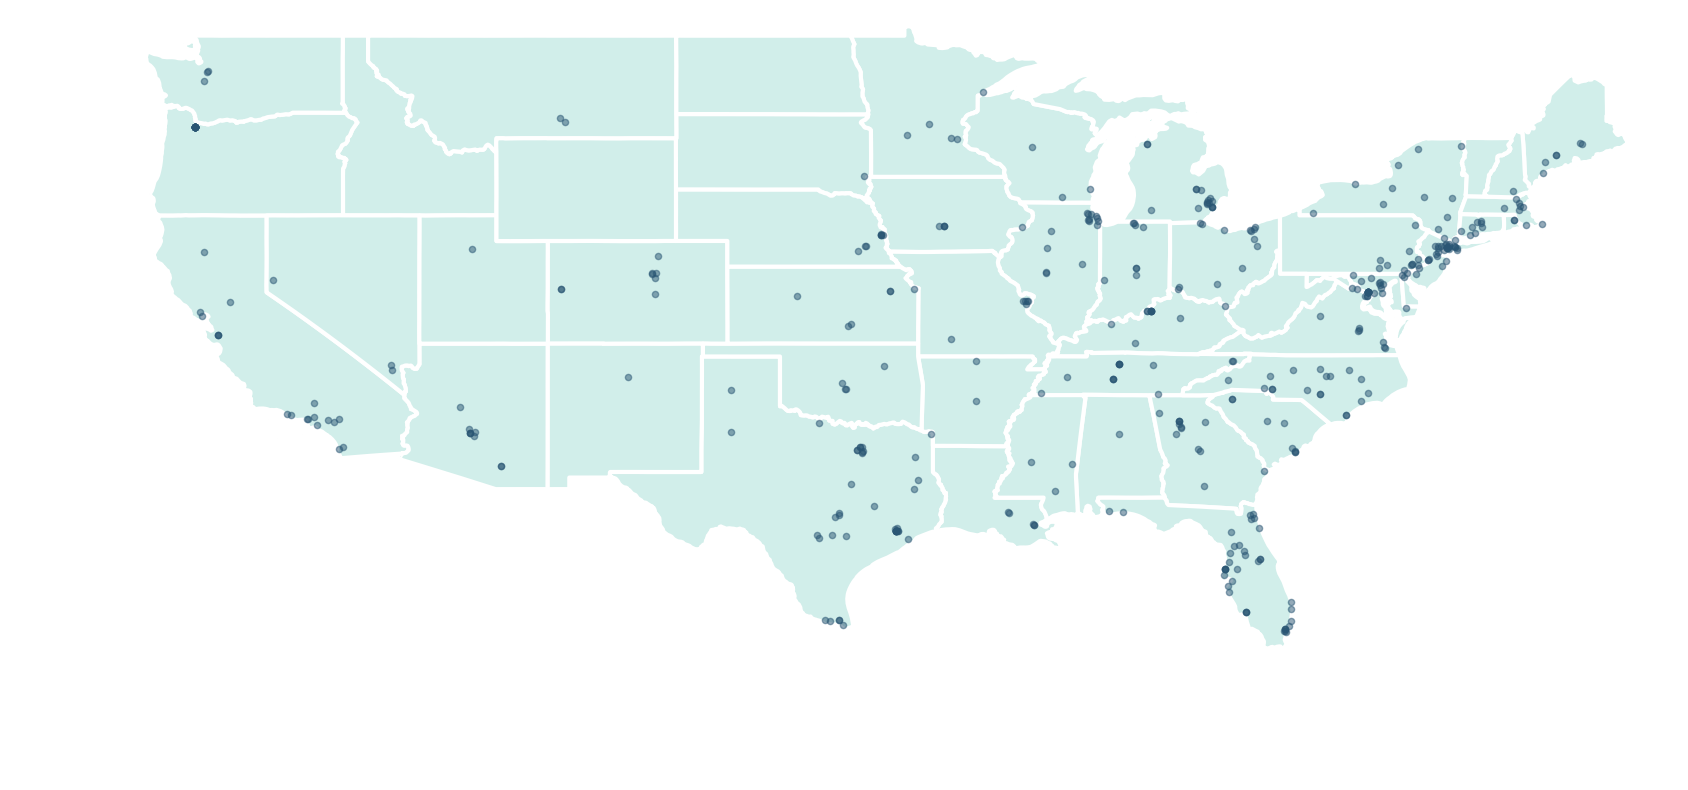

In [15]:
# load our usa shapefile
usa = gpd.read_file("shapefiles/cb_2017_us_state_20m/cb_2017_us_state_20m.shp")

# set up a geopandas data frame with our aco latitude and longitude
gdf = gpd.GeoDataFrame(aco_df, geometry=gpd.points_from_xy(aco_df["longitude"],aco_df["latitude"]))

# create an axis for our plot
ax = usa.plot(color="#d1eeea", linewidth=3, edgecolor='white', figsize=(25,10))

# set the plot limits to focus on the usa
ax.set_ylim([20, 50])
ax.set_xlim([-130, -65])

# add "dots" to our map
gdf.plot(markersize=20, color="#2a5674", alpha=0.5, ax=ax)

# turn off the x,y axis
ax.axis("off")

## Proportional symbol maps

Proportional symbol maps are a close cousin of dot density maps. The main difference is that with the former, we'll include some additional information in our map by making the size of the points proportional to some variable of interest. In the example below, we'll scale the size of the point relative to the savings rate of the ACO, which will give us a way of seeing whether there is any geographic clustering to performance. 

(-130.0, -65.0, 20.0, 50.0)

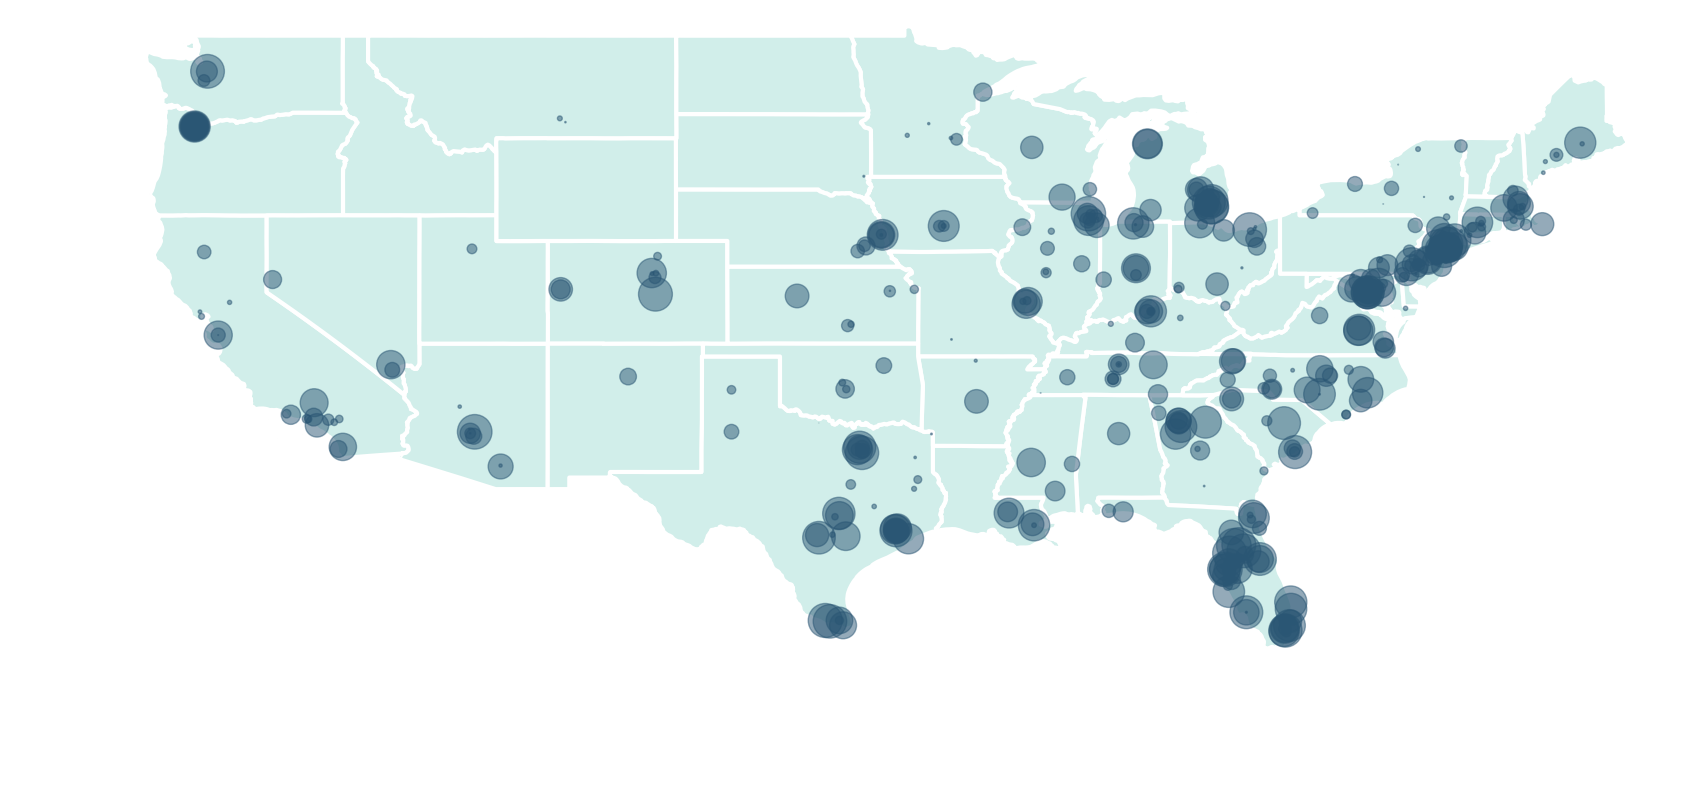

In [16]:
# load our usa shapefile
usa = gpd.read_file("shapefiles/cb_2017_us_state_20m/cb_2017_us_state_20m.shp")

# set up a geopandas data frame with our aco latitude and longitude
gdf = gpd.GeoDataFrame(aco_df, geometry=gpd.points_from_xy(aco_df["longitude"],aco_df["latitude"]))

# create an axis for our plot
ax = usa.plot(color="#d1eeea", linewidth=3, edgecolor='white', figsize=(25,10))

# set the plot limits to focus on the usa
ax.set_ylim([20, 50])
ax.set_xlim([-130, -65])

# add "dots" to our map
ms = (gdf["Sav_rate"].rank(pct=True)*25)**2 # getting your marker size right is a bit of an art
gdf.plot(markersize=ms, color="#2a5674", alpha=0.5, ax=ax)

# turn off the x,y axis
ax.axis("off")

As you are hopefully starting to see, these kinds of maps can be great for developing hypotheses. We do seem to see some evidence of geographic clustering (we'll test that more systematically later). What's going on, for example in Florida? Could this be evidence of localized learning? Or are the market conditions there more favorable to high performing ACOs?

## Choropleth maps

Choropleth maps are basically heat maps applied to a set of geographic boundaries. The idea is to fill in a geographic boundary with a color that is proportional to some variable of interest. To see how these maps work, let's try to recreate our dot density map but using the choropleth approach. So, colors will be proportional to the number of ACOs present in the state.

(-130.0, -65.0, 20.0, 50.0)

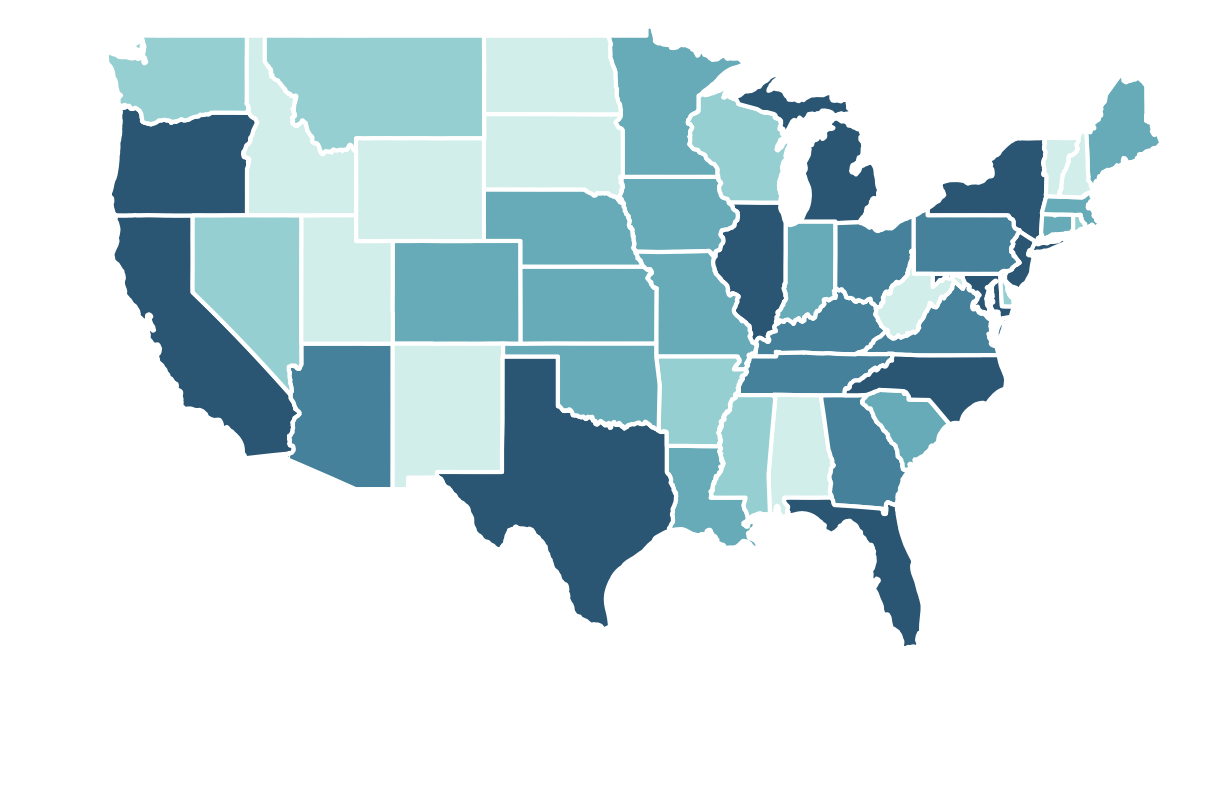

In [17]:
# load some nice colors from the cartocolors library
from palettable.cartocolors.sequential import Teal_7

# add a count of states to our data frame
usa["aco_count"] = usa.apply(lambda STATEFP: gdf.within(STATEFP.geometry).sum(), axis=1)

# build our choropleth map
ax = usa.plot(column='aco_count', 
              scheme='quantiles', 
              linewidth=3, edgecolor='white', 
              figsize=(25,10), 
              cmap=Teal_7.mpl_colormap)

# set the plot limits to focus on the usa
ax.set_ylim([20, 50])
ax.set_xlim([-130, -65])

# turn off the x,y axis
ax.axis("off")

# Spatial autocorrelation

Next, we'll explore some of the basics of spatial data modeling. In a nutshell, we'll be running regressions that model spatial dependencies through the use of weight matrices, which record information on the spatial proximity of observations. We'll make extensive use to the `pysal` Python package. As a heads up, the package can be quite a pain to install. If you have trouble, I would recommend using the Anaconda Python distribution, which makes installation easier (at least it did for me).

To get started, we'll load a few packages and define some variables based on the name of the ACO. We're mostly focused on these because they're easy to compute given the data we have at hand; but they are also of interest to the extent that they give us some information about things like organizational identity.

In [18]:
# load pysal
import libpysal

# load numpy
import numpy as np

# compute some variables
aco_df["name_length"] = aco_df["ACO_Name"].apply(len)
aco_df["name_has_network"] = aco_df["ACO_Name"].str.contains(pat = "network", case=False).astype(int)
aco_df["name_has_physician"] = aco_df["ACO_Name"].str.contains(pat = "physician", case=False).astype(int)

Next, we'll define some weight matrices. There are many different ways to define these matrices, and debates over their specification has led to something of a cottage industry in the literature; not without good reason, as model results can vary quite a bit based on the contruction of the weight matrix. We'll compute the weight matrix using a few common approaches. 

## k nearest neighbors

One common approach to defining the weight matrix is to focus on nearest neighbors. Specifically, we can compute the geographic distance between points, rank them from closest to farthest, and then choose the $n$ closest as neighbors. This is called the k nearest neighbors approach. We can define a weight matrix using this technique with just a few lines of code.

In [19]:
# get kd tree
kd = libpysal.cg.KDTree(aco_df[["latitude","longitude"]].values, 
                         distance_metric="Arc", 
                         radius = libpysal.cg.RADIUS_EARTH_KM)

# knn weights
wknn = libpysal.weights.KNN(data=kd, k=30, distance_metric="Arc") 

Let's investigate the weights a bit. We'll start by looking at the weights for the first aco in our data frame (aco 0).

In [20]:
wknn[0]

{7: 1.0,
 8: 1.0,
 10: 1.0,
 9: 1.0,
 5: 1.0,
 4: 1.0,
 6: 1.0,
 2: 1.0,
 3: 1.0,
 12: 1.0,
 1: 1.0,
 11: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 21: 1.0,
 17: 1.0,
 16: 1.0,
 20: 1.0,
 22: 1.0,
 19: 1.0,
 18: 1.0,
 23: 1.0,
 24: 1.0,
 59: 1.0,
 58: 1.0,
 55: 1.0,
 56: 1.0,
 25: 1.0,
 54: 1.0}

Notice that we're given a dictionary, where the key corresponds to the neighbor id, and the value corresponds to the weight (all 1s). We can also query weights by `ACO_Num`.

In [21]:
wknn[aco_df.index.get_loc("A91221")]

{391: 1.0,
 400: 1.0,
 398: 1.0,
 401: 1.0,
 399: 1.0,
 397: 1.0,
 388: 1.0,
 395: 1.0,
 404: 1.0,
 383: 1.0,
 396: 1.0,
 381: 1.0,
 382: 1.0,
 380: 1.0,
 385: 1.0,
 384: 1.0,
 394: 1.0,
 393: 1.0,
 379: 1.0,
 403: 1.0,
 402: 1.0,
 387: 1.0,
 386: 1.0,
 392: 1.0,
 410: 1.0,
 377: 1.0,
 378: 1.0,
 409: 1.0,
 407: 1.0,
 408: 1.0}

Now let's find the neighbors for aco 0.

In [22]:
wknn.neighbors[0]

[7,
 8,
 10,
 9,
 5,
 4,
 6,
 2,
 3,
 12,
 1,
 11,
 13,
 14,
 15,
 21,
 17,
 16,
 20,
 22,
 19,
 18,
 23,
 24,
 59,
 58,
 55,
 56,
 25,
 54]

We can also pull some data on each neighbor (from `aco_df`).

In [23]:
aco_df.iloc[wknn.neighbors[0]].head()

,ACO_Name,ACO_Address,ACO_Zip,Sav_rate,latitude,longitude,name_length,name_has_network,name_has_physician
ACO_Num,,,,,,,,,
A17931,Emerald Physicians,"433 West Main Street, Hyannis, Massachusetts, 02601","02601(41.656451, -70.299373)",0.026156,41.656451,-70.299373,18,0,1
A12533,"Southcoast Accountable Care Organization, LLC","101 Page Street, New Bedford, Massachusetts, 02740","02740(41.636061, -70.938743)",-0.006804,41.636061,-70.938743,45,0,0
A78144,"Coastal Medical, Inc.","10 Davol Square , Suite 400, Providence , Rhode Island, 02903","02903(41.82046, -71.412643)",0.021066,41.820460,-71.412643,21,0,0
A96182,"Lifespan Health Alliance, LLC","167 Point Street, Suite 2B, Providence, Rhode Island, 02903","02903(41.82046, -71.412643)",-0.021392,41.820460,-71.412643,29,0,0
A79410,"BMC Integrated Care Services, Inc.","One Boston Medical Center Place, Boston, Massachusetts, 02118","02118(42.338507, -71.07125)",-0.023872,42.338507,-71.071250,34,0,0


That's a nice sanity check. Notice that all the nearest neighbors are located in the southwest. Next, let's look at the full weight matrix.

In [24]:
wknn_matrix, ids = wknn.full()
wknn_matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

What is the dimensionality of the matrix? It should be $n\times n$, where $n$ is the number of ACOs.

In [25]:
wknn_matrix.shape

(437, 437)

We can also vizualize the matrix (using `matplotlib`) for good measure. Oh yeah, and remember how earlier we sorted `aco_df` by zip code? Thanks to that sorting, we'll see some structure in the plots of our weight matrices.

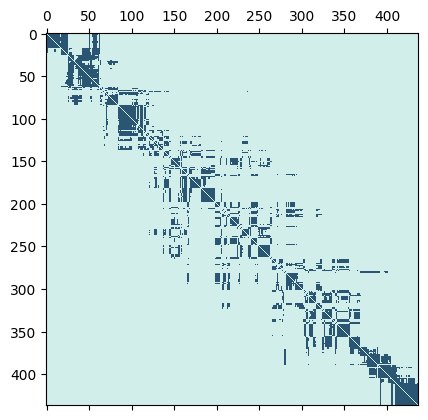

In [26]:
plt.matshow(wknn_matrix, cmap=Teal_7.mpl_colormap)

How many neighbors does each ACO have? Remember, it should be 30. Let's check.

In [27]:
wknn_matrix.sum(axis=1)

array([30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30

We can also check using `pysal`.

In [28]:
wknn.cardinalities

{0: 30,
 1: 30,
 2: 30,
 3: 30,
 4: 30,
 5: 30,
 6: 30,
 7: 30,
 8: 30,
 9: 30,
 10: 30,
 11: 30,
 12: 30,
 13: 30,
 14: 30,
 15: 30,
 16: 30,
 17: 30,
 18: 30,
 19: 30,
 20: 30,
 21: 30,
 22: 30,
 23: 30,
 24: 30,
 25: 30,
 26: 30,
 27: 30,
 28: 30,
 29: 30,
 30: 30,
 31: 30,
 32: 30,
 33: 30,
 34: 30,
 35: 30,
 36: 30,
 37: 30,
 38: 30,
 39: 30,
 40: 30,
 41: 30,
 42: 30,
 43: 30,
 44: 30,
 45: 30,
 46: 30,
 47: 30,
 48: 30,
 49: 30,
 50: 30,
 51: 30,
 52: 30,
 53: 30,
 54: 30,
 55: 30,
 56: 30,
 57: 30,
 58: 30,
 59: 30,
 60: 30,
 61: 30,
 62: 30,
 63: 30,
 64: 30,
 65: 30,
 66: 30,
 67: 30,
 68: 30,
 69: 30,
 70: 30,
 71: 30,
 72: 30,
 73: 30,
 74: 30,
 75: 30,
 76: 30,
 77: 30,
 78: 30,
 79: 30,
 80: 30,
 81: 30,
 82: 30,
 83: 30,
 84: 30,
 85: 30,
 86: 30,
 87: 30,
 88: 30,
 89: 30,
 90: 30,
 91: 30,
 92: 30,
 93: 30,
 94: 30,
 95: 30,
 96: 30,
 97: 30,
 98: 30,
 99: 30,
 100: 30,
 101: 30,
 102: 30,
 103: 30,
 104: 30,
 105: 30,
 106: 30,
 107: 30,
 108: 30,
 109: 30,
 110: 30,


Finally, for reasons that we will not discuss in detail, when incorporating a weight matrix into a statistical (e.g., regression) type model, you will typically want to normalize the matrix. We can do row normalization easy in `pysal`.

In [29]:
# row normalize
wknn.transform = "R"

Now let's check to see if it worked by getting the full matrix again and summing the rows (which should now add to 1).

In [30]:
wknn_matrix, ids = wknn.full()
wknn_matrix.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Looks good. Yay!

## Distance bands
Another approach to defining the weight matrix is to begin with some distance threshold (i.e., a radius) of interest and then consider all points within that radius (around a focal point) to be neighbors. Note that while with the kNN approach, each point will have the same number of neighbors, using the distance band technique, the number of neighbors can vary. Returned distances from KDTree are based on the units of the radius given, the default being kilometers.

In [31]:
# get kd tree
kd = libpysal.cg.KDTree(aco_df[["latitude","longitude"]].values, 
                         distance_metric="Arc", 
                         radius = libpysal.cg.RADIUS_EARTH_KM)

# distance band weights
wdb = libpysal.weights.DistanceBand(kd, 
                                     threshold=100, 
                                     distance_metric="Arc", 
                                     silence_warnings=True)

Now let's investigate the weights. We can start by looking at the weights for the first ACO. 

In [32]:
wdb[0]

{}

Right off the bat, we see that there is a difference between the kNN and the distance band weights. Whereas with the kNN weights, each ACO had an identical number of neighbors ($k$), using the distance band approach, the number of weights will vary, and we see that ACO 0 has 0 neighbors. Next, let's pull the full weight matrix.

In [33]:
wdb_matrix, ids = wdb.full()
wdb_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

Now let's visualize the matrix.

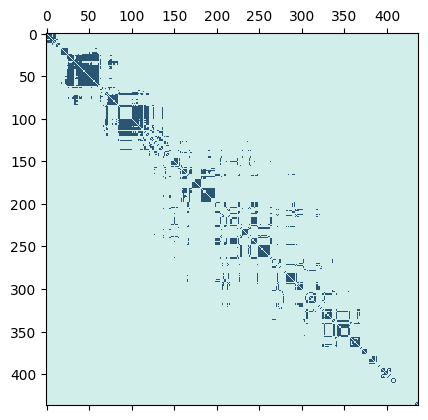

In [34]:
plt.matshow(wdb_matrix, cmap=Teal_7.mpl_colormap)

Finally, let's row normalize our weights.

In [35]:
# row normalize
wdb.transform = "R"

## Moran's I
Previously, when we were doing some exploratory data analysis, we noticed that there seemed to be some spatial correlation in savings rate (i.e., from our proportional symbol map). Wouldn't it be nice if there was some way to evaluate the strength of our intuitions? There are a number of different ways we can evaluate spatial relationships statistically. One of the simplest and most widely used is called Moran's I. You can read more about Moran's I [here](https://en.wikipedia.org/wiki/Moran%27s_I). Briefly, Moran's I will be negative when -1 when dissimilar ACOs are closer together, 0 when they are randomly arranged, and +1 when similar ACOs are closer together. 

In [36]:
import esda
mi = esda.Moran(y = aco_df["Sav_rate"], 
                              w = wdb, 
                              transformation = "R",
                              two_tailed=True)
print(mi.I, mi.EI, mi.p_norm)

0.0766554117751406 -0.0022935779816513763 0.0008210611749535639


So confirming our hunch, we have statistical evidence of spatial autocorrelation, such that ACOs tend to cluster together by performance.

## OLS
Independence is one of the basic assumptions of OLS regression, i.e., that values for observation $i$ are not influenced by those of the other observations. If we observe spatial clustering in our data, this assumption is likely violated. (Actually, I would argue that the independence assumption is probably violated in almost any study of a social phenomenon, although not often recognized, but don't get me started...) By incorporating our weights, we can easily detect spatial autocorrelation in an OLS regression model. Before we get started, let's prepare our data for regression modeling.

In [69]:
# prepare y
y = np.array(aco_df["Sav_rate"])
y.shape = (len(aco_df), 1)

# prepare X
X = []
X.append(aco_df["name_has_network"])
X.append(aco_df["name_has_physician"])
X = np.array(X).T

To begin, let's run a plain old OLS model, with no spatial information incorporated.

In [70]:
import spreg
ols = spreg.OLS(y=y,
                x=X,
                spat_diag=False,
                nonspat_diag=False,
                moran=False)
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:         437
Mean dependent var  :      0.0131                Number of Variables   :           3
S.D. dependent var  :      0.0479                Degrees of Freedom    :         434
R-squared           :      0.0112
Adjusted R-squared  :      0.0066

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     t-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.01339         0.00250         5.34999         0.00000
               var_1        -0.01188         0.00752        -1.57987         0.11486
               var_2         0.01310         0.00877        

Next, let's run a model that incorporates our kNN spatial weights. Remember that we already row normalized our weights.

In [71]:
ols_wknn = spreg.OLS(y=y,
                    x=X,
                    w=wknn,
                    spat_diag=True,
                    nonspat_diag=False,
                    moran=True)
print(ols_wknn.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         437
Mean dependent var  :      0.0131                Number of Variables   :           3
S.D. dependent var  :      0.0479                Degrees of Freedom    :         434
R-squared           :      0.0112
Adjusted R-squared  :      0.0066

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     t-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.01339         0.00250         5.34999         0.00000
               var_1        -0.01188         0.00752        -1.57987         0.11486
               var_2         0.01310         0.00877        

So it looks like our model is misspecified (due to missing spatial lags) according to the Lagrange Multiplier. Finally, let's run a model with our distance band weights.

In [72]:
ols_wdb = spreg.OLS(y=y,
                    x=X,
                    w=wdb,
                    spat_diag=True,
                    nonspat_diag=False,
                    moran=True)
print(ols_wdb.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         437
Mean dependent var  :      0.0131                Number of Variables   :           3
S.D. dependent var  :      0.0479                Degrees of Freedom    :         434
R-squared           :      0.0112
Adjusted R-squared  :      0.0066

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     t-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.01339         0.00250         5.34999         0.00000
               var_1        -0.01188         0.00752        -1.57987         0.11486
               var_2         0.01310         0.00877        

Again, we have evidence of model misspecification due to missing spatial lags.

## Maximum likelihood model

Finally, let's run a spatial autocorrelation model with an endogenous spatial lag.

In [44]:
ml_wknn = spreg.ml_lag.ML_Lag(y=y,
                              x=X,
                              w=wknn, 
                              name_x=[f"x{i}" for i in range(X.shape[1])])
print(ml_wknn.summary)

<class 'numpy.ndarray'>
(437, 1)


In [85]:
ml_wdb = spreg.ml_lag.ML_Lag(y=y,
                             x=X,
                             w=wdb,
                             name_x=[f"x{i}" for i in range(X.shape[1])])
print(ml_wdb.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         437
Mean dependent var  :      0.0131                Number of Variables   :           4
S.D. dependent var  :      0.0479                Degrees of Freedom    :         433
Pseudo R-squared    :      0.0344
Spatial Pseudo R-squared:  0.0103
Log likelihood      :    714.2906
Sigma-square ML     :      0.0022                Akaike info criterion :   -1420.581
S.E of regression   :      0.0471                Schwarz criterion     :   -1404.262

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

# Further reading
In addition to the package documentation, I found these readings helpful when putting this notebook together.
  * [Mapping with geopandas](http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/)
  * [Introduction to Geospatial Data in Python](https://www.datacamp.com/community/tutorials/geospatial-data-python)
  * [Geographic Data Science](http://darribas.org/gds15)
  * [Geographic Data Science with PySAL and the pydata stack](http://darribas.org/gds_scipy16)

# Exercises

* Update the proportional symbol map above to plot a different variable of interest from the ACO data.
* Re-run the OLS models above with exogenous and exogenous spatial lags (hint: you'll want to dig around the `pysal` documentation).
* Define a weight matrix where distances are based not on geographic distances, but rather "social" distances, in the sense of path distances in a network.
* Re-create the maps above, but rather than using shapefiles for states, use Hospital Service Areas or Hospital Referral Regions from the Dartmouth Atlas (data linked above).